In [19]:
import numpy as np
import os
from sklearn.model_selection import KFold
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tensorflow.keras.layers import Dense , Dropout
from scikeras.wrappers import KerasRegressor 
from tensorflow.keras.callbacks import EarlyStopping
import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import GridSearchCV

In [20]:
#data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/TPath_300_finish_data.pkl')
data = pd.read_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/Finish_ALL_D3_500_I_F_PKL.pkl')

data

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
0,0.0000,-0.00200,100,6000,5000,449.80
1,0.0000,-0.00192,100,6000,5000,479.76
2,0.0000,-0.00184,100,6000,5000,506.60
3,0.0000,-0.00176,100,6000,5000,530.80
4,0.0000,-0.00168,100,6000,5000,552.15
...,...,...,...,...,...,...
351283,0.0024,0.00168,500,9000,5000,1365.50
351284,0.0024,0.00176,500,9000,5000,1247.20
351285,0.0024,0.00184,500,9000,5000,1114.10
351286,0.0024,0.00192,500,9000,5000,983.97


In [3]:
bedingung = (data['Kraft'] == 6000) & (data['Strom'] == 7000)
df_test = data[bedingung].copy()
print(df_test)
#df_test.to_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/Finish_I7000_F6000_D3_500_I_F_PKL.pkl')
data_all = data.drop(df_test.index)
#print(data_all)
print(data_all[(data_all['Kraft'] == 6000) & (data_all['Strom'] == 7000)])
df_test

         X-Koordinate  Y-Koordinate  Zeitpunkt  Strom  Kraft  Temperatur
1037169       0.00000      -0.00200        500   7000   6000      811.76
1037170       0.00000      -0.00196        500   7000   6000      853.27
1037171       0.00000      -0.00192        500   7000   6000      897.57
1037172       0.00000      -0.00188        500   7000   6000      941.21
1037173       0.00000      -0.00184        500   7000   6000      986.34
...               ...           ...        ...    ...    ...         ...
1043527       0.00248       0.00184        500   7000   6000      784.55
1043528       0.00248       0.00188        500   7000   6000      745.87
1043529       0.00248       0.00192        500   7000   6000      706.17
1043530       0.00248       0.00196        500   7000   6000      693.28
1043531       0.00248       0.00200        500   7000   6000      687.80

[6363 rows x 6 columns]
Empty DataFrame
Columns: [X-Koordinate, Y-Koordinate, Zeitpunkt, Strom, Kraft, Temperatur]
Index: [

,X-Koordinate,Y-Koordinate,Zeitpunkt,Strom,Kraft,Temperatur
1037169,0.00000,-0.00200,500,7000,6000,811.76
1037170,0.00000,-0.00196,500,7000,6000,853.27
1037171,0.00000,-0.00192,500,7000,6000,897.57
1037172,0.00000,-0.00188,500,7000,6000,941.21
1037173,0.00000,-0.00184,500,7000,6000,986.34
...,...,...,...,...,...,...
1043527,0.00248,0.00184,500,7000,6000,784.55
1043528,0.00248,0.00188,500,7000,6000,745.87
1043529,0.00248,0.00192,500,7000,6000,706.17
1043530,0.00248,0.00196,500,7000,6000,693.28


In [4]:
data_all = data_all.drop('Zeitpunkt', axis = 1)
data_all

,X-Koordinate,Y-Koordinate,Strom,Kraft,Temperatur
254520,0.00000,-0.00200,6000,5000,7.535400e+02
254521,0.00000,-0.00196,6000,5000,7.936300e+02
254522,0.00000,-0.00192,6000,5000,8.356500e+02
254523,0.00000,-0.00188,6000,5000,8.775000e+02
254524,0.00000,-0.00184,6000,5000,9.199800e+02
...,...,...,...,...,...
2087059,0.00248,0.00184,9000,5000,1.110600e+03
2087060,0.00248,0.00188,9000,5000,1.046600e+03
2087061,0.00248,0.00192,9000,5000,9.810900e+02
2087062,0.00248,0.00196,9000,5000,7.888600e-31


In [5]:
data_all = data_all.sample(frac=1, random_state=42)  # Hier wird 42 als Random State verwendet, um die Ergebnisse reproduzierbar zu machen
df_reset = data_all.reset_index(drop=True)
df_reset

,X-Koordinate,Y-Koordinate,Strom,Kraft,Temperatur
0,0.00112,-0.00064,6000,6000,1617.10
1,0.00108,-0.00036,8000,7000,2058.20
2,0.00136,0.00096,6000,6000,1420.30
3,0.00064,0.00028,6000,5000,1829.90
4,0.00048,0.00188,6000,6000,693.83
...,...,...,...,...,...
44536,0.00248,-0.00188,6000,5000,842.80
44537,0.00192,0.00092,6000,6000,1342.80
44538,0.00248,0.00124,8000,7000,1434.90
44539,0.00032,0.00008,6000,5000,1873.40


In [6]:
y = df_reset["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
X = df_reset.drop("Temperatur", axis=1)

print(X[(X['Kraft'] == 6000) & (X['Strom'] == 7000)])

Empty DataFrame
Columns: [X-Koordinate, Y-Koordinate, Strom, Kraft]
Index: []


In [7]:
label = df_test["Temperatur"]
# Korrektur: Verwenden Sie den Spaltennamen direkt, ohne Indexierung der columns-Eigenschaft
X_2 = df_test.drop("Temperatur", axis=1)
X_2 = X_2.drop('Zeitpunkt',axis =1)
X_2 = X_2.reset_index(drop=True)
y_2 = label

In [8]:
X_2

,X-Koordinate,Y-Koordinate,Strom,Kraft
0,0.00000,-0.00200,7000,6000
1,0.00000,-0.00196,7000,6000
2,0.00000,-0.00192,7000,6000
3,0.00000,-0.00188,7000,6000
4,0.00000,-0.00184,7000,6000
...,...,...,...,...
6358,0.00248,0.00184,7000,6000
6359,0.00248,0.00188,7000,6000
6360,0.00248,0.00192,7000,6000
6361,0.00248,0.00196,7000,6000


In [9]:
y

0        1617.10
1        2058.20
2        1420.30
3        1829.90
4         693.83
          ...   
44536     842.80
44537    1342.80
44538    1434.90
44539    1873.40
44540    2010.50
Name: Temperatur, Length: 44541, dtype: float64

In [10]:
 # train_df enthält 80% der Daten, test_df enthält 20% der Daten
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [11]:
# Initialisiere einen MinMaxScaler für die Features
scaler_features = MinMaxScaler()
scaler_features2 = MinMaxScaler()
# Skaliere X_train und X_test
X_train_scaled = scaler_features.fit_transform(X)
#X_test_scaled = scaler_features.transform(X_test)  # Nutze gleiche Skalierungsparameter ohne das X_Test Informationen einfließen
X_test_scaled_2 = scaler_features.transform(X_2)  # Nutze gleiche Skalierungsparameter ohne das X_Test Informationen einfließen

# Initialisiere einen SEPARATEN MinMaxScaler für das Ziel, wenn nötig
scaler_target = MinMaxScaler()


# Skaliere y_train und y_test. Beachte, dass y_train.reshape(-1, 1) verwendet wird, da MinMaxScaler 
# erwartet, dass die Eingaben als 2D-Arrays kommen, und Ziele normalerweise als 1D-Arrays vorliegen.
y_train_scaled = scaler_target.fit_transform(y.values.reshape(-1, 1))
#y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))
y_test_scaled_2 = scaler_target.transform(y_2.values.reshape(-1, 1))


In [12]:
X_test_scaled_2

array([[0.        , 0.        , 0.33333333, 0.25      ],
       [0.        , 0.01      , 0.33333333, 0.25      ],
       [0.        , 0.02      , 0.33333333, 0.25      ],
       ...,
       [1.        , 0.98      , 0.33333333, 0.25      ],
       [1.        , 0.99      , 0.33333333, 0.25      ],
       [1.        , 1.        , 0.33333333, 0.25      ]])

In [13]:
y_train_scaled.max()

1.0

In [71]:
# Netzwerkarchitektur
model = Sequential([

    Dense(136, activation='relu', input_shape=(4,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

    Dense(216, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(104, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(328, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(8, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(120, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
    
    Dense(1 , activation = 'linear')
])

# Optimierer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  #0.0001

# Modell kompilieren (Verwendung von mean_squared_error als Verlustfunktion für Regression)
model.compile(optimizer=optimizer,
              loss='mean_squared_error',
              metrics=['mae'])  # Metriken für Regression: Mean Absolute Error und Mean Squared Error

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# Trainingsparameter
batch_size = 25   #25
epochs = 1000

# Modell trainieren (Annahme: X_train, y_train, X_val, y_val sind vordefiniert)
history = model.fit(X_train_scaled, y_train_scaled,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/1000
1426/1426 [==============================] - 3s 2ms/step - loss: 0.1333 - mae: 0.2625 - val_loss: 0.0461 - val_mae: 0.1473
Epoch 2/1000
1426/1426 [==============================] - 2s 2ms/step - loss: 0.0309 - mae: 0.0984 - val_loss: 0.0172 - val_mae: 0.0449
Epoch 3/1000
1426/1426 [==============================] - 2s 2ms/step - loss: 0.0145 - mae: 0.0235 - val_loss: 0.0136 - val_mae: 0.0159
Epoch 4/1000
1426/1426 [==============================] - 2s 2ms/step - loss: 0.0130 - mae: 0.0133 - val_loss: 0.0123 - val_mae: 0.0075
Epoch 5/1000
1426/1426 [==============================] - 2s 2ms/step - loss: 0.0120 - mae: 0.0097 - val_loss: 0.0117 - val_mae: 0.0106
Epoch 6/1000
1426/1426 [==============================] - 2s 2ms/step - loss: 0.0112 - mae: 0.0102 - val_loss: 0.0107 - val_mae: 0.0076
Epoch 7/1000
1426/1426 [==============================] - 2s 2ms/step - loss: 0.0103 - mae: 0.0089 - val_loss: 0.0098 - val_mae: 0.0081
Epoch 8/1000
1426/1426 [========================

In [15]:
# Initialisiere Listen, um Ergebnisse zu speichern
val_loss_results = []
val_mae_results = []

# Funktion, um das Modell zu erstellen
def create_model():
    model = Sequential([
            Dense(136, activation='relu', input_shape=(4,), kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),

            Dense(216, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
            
            Dense(104, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
            
            Dense(328, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
            
            Dense(8, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
            
            Dense(120, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001)),
            
            Dense(1 , activation = 'linear')

    ])
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# K-Fold Cross-Validation Konfiguration
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Leistungsüberwachung
fold_no = 1
for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train_scaled[train_index], y_train_scaled[val_index]

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

    print(f'Training für Fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold, batch_size=25, epochs=1000, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=1)

    # Speichere die Ergebnisse des aktuellen Folds
    val_loss_results.append(min(history.history['val_loss']))
    val_mae_results.append(min(history.history['val_mae']))

    fold_no += 1

# Berechne den Durchschnitt über alle Folds
average_val_loss = np.mean(val_loss_results)
average_val_mae = np.mean(val_mae_results)
# 
# Umwandeln der Listen in Pandas DataFrames
val_loss_df = pd.DataFrame(val_loss_results, columns=['Validation Loss'])
val_mae_df = pd.DataFrame(val_mae_results, columns=['Validation MAE'])

# Speichern der DataFrames in CSV-Dateien
val_loss_df.to_csv('val_loss_results_D3_I_F_1.csv', index=False)
val_mae_df.to_csv('val_mae_results_D3_I_F_1.csv', index=False)

# Gib die durchschnittlichen Ergebnisse aus
print(f'Durchschnittlicher Validation Loss: {average_val_loss}')
print(f'Durchschnittlicher Validation MAE: {average_val_mae}')


Training für Fold 1...
Epoch 1/1000
1426/1426 [==============================] - 4s 2ms/step - loss: 0.0443 - mae: 0.0877 - val_loss: 0.0146 - val_mae: 0.0231
Epoch 2/1000
1426/1426 [==============================] - 2s 1ms/step - loss: 0.0135 - mae: 0.0155 - val_loss: 0.0126 - val_mae: 0.0091
Epoch 3/1000
1426/1426 [==============================] - 2s 1ms/step - loss: 0.0125 - mae: 0.0142 - val_loss: 0.0119 - val_mae: 0.0117
Epoch 4/1000
1426/1426 [==============================] - 2s 1ms/step - loss: 0.0116 - mae: 0.0113 - val_loss: 0.0111 - val_mae: 0.0071
Epoch 5/1000
1426/1426 [==============================] - 2s 1ms/step - loss: 0.0110 - mae: 0.0119 - val_loss: 0.0111 - val_mae: 0.0218
Epoch 6/1000
1426/1426 [==============================] - 2s 1ms/step - loss: 0.0103 - mae: 0.0097 - val_loss: 0.0099 - val_mae: 0.0065
Epoch 7/1000
1426/1426 [==============================] - 2s 1ms/step - loss: 0.0098 - mae: 0.0105 - val_loss: 0.0093 - val_mae: 0.0076
Epoch 8/1000
1426/1426 [=

In [16]:
results = model.evaluate(X_test_scaled_2, y_test_scaled_2, verbose=2)
results

199/199 - 0s - loss: 1.2498e-04 - mae: 0.0032 - 344ms/epoch - 2ms/step


[0.00012498479918576777, 0.003247056854888797]

In [17]:

scaled_predicted_values = model.predict(X_test_scaled_2, verbose = 0)

# Führen Sie die Rücktransformation der skalierten Werte durch
original_predicted_values = scaler_target.inverse_transform(scaled_predicted_values)
original_actual_values = scaler_target.inverse_transform(y_test_scaled_2)  # y_test sind die skalierten tatsächlichen Werte
print(f' Bsp. Predicted: {original_predicted_values[100]} Actual: {original_actual_values[100]} ')

def calculate_mae(list1, list2):
    # Stelle sicher, dass beide Listen die gleiche Länge haben
    if len(list1) != len(list2):
        raise ValueError("Listen müssen die gleiche Länge haben")

    # Berechne die absolute Differenz zwischen den Elementen der Listen
    differences = [abs(x - y) for x, y in zip(list1, list2)]

    # Berechne den Durchschnitt der absoluten Differenzen
    mae = sum(differences) / len(differences)

    return mae

# Beispiel
list1 = original_predicted_values
list2 = original_actual_values

mae = calculate_mae(list1, list2)
print(f"Durchschnittliche Abweichung (MAE): {mae}")

errors = np.abs((original_actual_values - original_predicted_values) / original_actual_values)
mape = np.mean(errors) * 100
print(mape)

 Bsp. Predicted: [711.159] Actual: [735.96] 
Durchschnittliche Abweichung (MAE): [8.36831373]
0.6024003836854117


In [66]:
def calculate_r_squared(predicted, actual):
    # Berechnung des Mittelwerts der tatsächlichen Werte
    mean_actual = sum(actual) / len(actual)
    
    # Berechnung der totalen Summe der Quadrate (SST)
    sst = sum((x - mean_actual) ** 2 for x in actual)
    
    # Berechnung der Summe der Quadrate der Residuen (SSE)
    sse = sum((actual[i] - predicted[i]) ** 2 for i in range(len(actual)))
    
    # Berechnung des R^2-Wertes
    r_squared = 1 - (sse / sst)
    
    return r_squared

# Berechnung von R^2 mit den bereitgestellten Listen
r_squared = calculate_r_squared(list1, list2)

print(f"R^2: {r_squared}")

R^2: [0.99873581]


In [18]:
df_result = pd.DataFrame({'Echt': [val[0] for val in list2], 'Temperatur': [val[0] for val in list1]})
df_result['X-Koordinate'] = X_test_scaled_2[:, 0]
df_result['Y-Koordinate'] = X_test_scaled_2[:, 1]

df_result['Differenz'] = df_result['Echt'] - df_result['Temperatur']
df_result['Differenz'].sort_values()
sorted_df = df_result.sort_values(by= 'Differenz')
Anzahl_Punkte = (sorted_df['Differenz'] > 20).sum()
print("Anzahl der Werte die kleiner sind:", Anzahl_Punkte)

sorted_df

Anzahl der Werte die kleiner sind: 183


,Echt,Temperatur,X-Koordinate,Y-Koordinate,Differenz
21,1644.20,1667.433105,0.000000,0.21,-23.233105
423,1588.10,1611.326660,0.064516,0.19,-23.226660
322,1588.40,1611.395996,0.048387,0.19,-22.995996
424,1616.30,1639.162109,0.064516,0.20,-22.862109
425,1643.40,1666.239624,0.064516,0.21,-22.839624
...,...,...,...,...,...
5958,693.10,656.139709,0.935484,1.00,36.960291
6059,691.77,654.232788,0.951613,1.00,37.537212
6160,690.48,652.304260,0.967742,1.00,38.175740
6261,689.09,650.375732,0.983871,1.00,38.714268


In [41]:
df_test['Vorhergesagt'] = list1
df_test.to_pickle('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Daten/Finish/Finish_I7000_F6000_D3_500_I_F_PKL_Prediction.pkl')

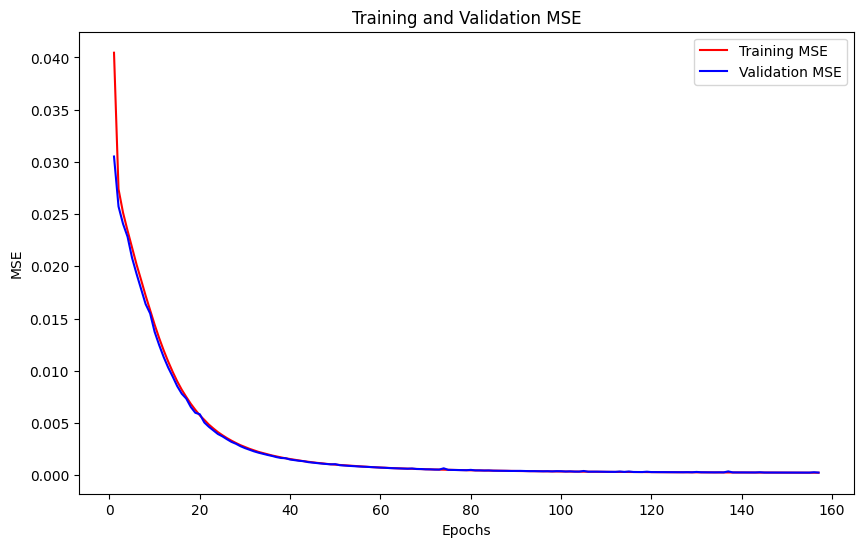

In [81]:
mae = history.history['loss']
val_mae = history.history['val_loss']

epochs = range(1, len(mae) + 1)

# MAE Diagramm
plt.figure(figsize=(10, 6))
plt.plot(epochs, mae, 'r', label='Training MSE')
plt.plot(epochs, val_mae, 'b', label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('C:/Users/erikm/Desktop/Diplomarbeit Erik Marr/Bilder Diplomarbeit/MSE_NeuroNetz/MSE_NeuroNetz_D3_2')

plt.show()


# GridSearch

In [49]:
# def build_model(learning_rate=0.001, activation='relu', regularization=0.0001, dropout_rate=0.0):
#     model = Sequential()
#     model.add(Dense(200, activation=activation, input_shape=(2,), kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(448, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(352, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(320, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(256, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(416, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(128, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(96, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))    
# 
#     model.add(Dense(32, activation=activation, kernel_initializer='he_uniform', kernel_regularizer=l2(regularization)))
#     model.add(Dropout(dropout_rate))
# 
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
#     return model
# 
# # Verwenden Sie eine Funktion, um das Modell zu instanziieren, für scikit-learn Wrapper
# model = KerasRegressor(model=build_model, verbose=2)
# 
# # Anpassung der Parameter im param_grid
# param_grid = {
#     'model__learning_rate': [0.01, 0.001, 0.0001],
#     'model__regularization': [0.001, 0.0001, 0.00001],
#     'fit__batch_size': [25, 50, 75, 100],
#     'fit__epochs': [50],
#     'model__dropout_rate' : [0.0, 0.1, 0.2]
# }
# 
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
# # Hinweis: Stellen Sie sicher, dass Ihre Daten (X_train_scaled, y_train_scaled) korrekt definiert sind
# grid_result = grid_search.fit(X_train_scaled, y_train_scaled)
# # Beste Parameter und Score ausgeben
# print("Beste Parameter:", grid_search.best_params_)
# print("Beste Genauigkeit:", grid_search.best_score_)
# 
# with open("Gridsearch_D3.txt", "w") as f:
#     f.write(f"Beste Parameter: {grid_search.best_params_}\n")
#     f.write(f"Beste Genauigkeit: {grid_search.best_score_}")


# Random Search

In [50]:
# # Funktion zum Erstellen des Modells
# def build_model(hp):
#     model = Sequential()
#     model.add(Dense(hp.Int('input_units', min_value=8, max_value=328, step=16), input_shape=(2,), activation='relu'))
#     for i in range(hp.Int('n_layers', 1, 10)):
#         model.add(Dense(hp.Int(f'units_{i}', min_value=8, max_value=328, step=16), activation='relu'))
#     model.add(Dense(1, activation='linear'))
#     model.compile(optimizer='adam', loss='mean_squared_error')
#     return model
# 
# # Durchführung der Random Search dreimal
# for run in range(1, 4):
#     # Anpassen des Verzeichnisses und des Projektnamens für jeden Durchlauf
#     directory = 'random_search'
#     project_name = f'random_search_D3_{run}'
#     
#     tuner = RandomSearch(
#         build_model,
#         objective='val_loss',
#         max_trials=100,
#         executions_per_trial=1,
#         directory=directory,
#         project_name=project_name
#     )
#     
#     # Durchführung des Random Search
#     tuner.search(X_train_scaled, y_train_scaled, epochs=50, verbose =0, batch_size=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
#     
#     # Abrufen und Speichern des besten Modells
#     best_model = tuner.get_best_models(num_models=1)[0]
#     model_path = os.path.join(directory, project_name, 'best_model.h5') 
#     best_model.save(model_path)
#     
# 
#     # Optional: Abrufen und Ausgeben der besten Hyperparameter
#     best_hyperparameters = tuner.get_best_hyperparameters()[0]
#     
#     # Konvertieren der Hyperparameter in ein DataFrame
#     df_hyperparameters = pd.DataFrame([best_hyperparameters.values])
#     # Speichern des DataFrame als CSV
#     df_hyperparameters.to_csv(f'random_search_D3_{run}.csv', index=False)
#     
#     print(f"Beste Hyperparameter für Lauf {run}: {best_hyperparameters.values}")